In [44]:
# import relevant python libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima 

ImportError: dlopen(/Users/user/Library/Caches/pypoetry/virtualenvs/hts-forecast-cpnzpCv1-py3.8/lib/python3.8/site-packages/sklearn/__check_build/_check_build.cpython-38-darwin.so, 2): Symbol not found: ____chkstk_darwin
  Referenced from: /Users/user/Library/Caches/pypoetry/virtualenvs/hts-forecast-cpnzpCv1-py3.8/lib/python3.8/site-packages/sklearn/__check_build/../.dylibs/libomp.dylib (which was built for Mac OS X 10.15)
  Expected in: /usr/lib/libSystem.B.dylib
 in /Users/user/Library/Caches/pypoetry/virtualenvs/hts-forecast-cpnzpCv1-py3.8/lib/python3.8/site-packages/sklearn/__check_build/../.dylibs/libomp.dylib
___________________________________________________________________________
Contents of /Users/user/Library/Caches/pypoetry/virtualenvs/hts-forecast-cpnzpCv1-py3.8/lib/python3.8/site-packages/sklearn/__check_build:
__init__.py               __pycache__               setup.py
_check_build.cpython-38-darwin.so
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it: run `python setup.py install` or
`make` in the source directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.

In [3]:
# import sales evaluation file 
df1 = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/sales_train_evaluation.csv')
df1.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [4]:
df1.shape

(30490, 1947)

In [5]:
# sum the total sales per item and put them in ascending order
df1.sum(axis=1).sort_values(ascending = False)

8412     253859
18055    195120
21104    151862
8908     136269
2314     128855
          ...  
10458        23
20192        18
27606        16
26276        16
6048         15
Length: 30490, dtype: int64

In [6]:
# sum the total sales per group of items
df1.groupby('dept_id').sum()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
dept_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1,2343,2216,1657,1508,1209,1897,1903,2235,1925,1586,...,4130,4257,4225,3264,3119,3073,3251,3735,4195,4031
FOODS_2,4094,4209,3174,3606,2869,4375,3349,4384,4273,3684,...,5842,7563,9069,6226,5311,4648,4551,4815,5940,6535
FOODS_3,16741,16333,12343,13764,10525,15821,15238,21132,18664,13631,...,20135,24756,28153,19668,17718,17069,16935,19586,23464,25401
HOBBIES_1,3610,3172,2497,2531,1714,3133,2855,3831,2741,2514,...,3422,4414,4464,3109,3142,3291,3027,3761,4832,4720
HOBBIES_2,154,185,185,138,100,87,89,155,158,101,...,449,479,552,419,487,449,448,382,501,560
HOUSEHOLD_1,4105,3858,2827,2732,1802,2664,3161,4334,3494,2857,...,7936,10042,10572,7609,6999,6641,6759,7974,9668,10165
HOUSEHOLD_2,1584,1776,1100,1133,927,1234,1415,1861,1481,1199,...,2159,2797,2886,2067,2001,1925,1992,2299,2918,2926


Let's take FOODS_3 as our group of items as it has the most sales and will provide more straight forward modelling: 

In [7]:
df2 = df1[df1.dept_id == 'FOODS_3']
df2.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
2226,FOODS_3_001_CA_1_evaluation,FOODS_3_001,FOODS_3,FOODS,CA_1,CA,1,1,1,1,...,0,0,0,1,0,0,1,0,0,2
2227,FOODS_3_002_CA_1_evaluation,FOODS_3_002,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,5,1,5,2,1,0,1,0,1,1
2228,FOODS_3_003_CA_1_evaluation,FOODS_3_003,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,0,1,0,0,0,2,2,0,0
2229,FOODS_3_004_CA_1_evaluation,FOODS_3_004,FOODS_3,FOODS,CA_1,CA,0,0,0,0,...,0,1,0,0,1,1,0,2,2,1
2230,FOODS_3_005_CA_1_evaluation,FOODS_3_005,FOODS_3,FOODS,CA_1,CA,1,0,1,2,...,1,2,0,0,0,0,0,1,0,1


In [8]:
df2.shape

(8230, 1947)

In [9]:
# Check if the number of rows in df2 matches the count for FOODS_3 in df1
df1.groupby('dept_id')['dept_id'].agg('count')

dept_id
FOODS_1        2160
FOODS_2        3980
FOODS_3        8230
HOBBIES_1      4160
HOBBIES_2      1490
HOUSEHOLD_1    5320
HOUSEHOLD_2    5150
Name: dept_id, dtype: int64

In [10]:
# Drop unnecessary columns 
df3 = df2.drop(['id', 'dept_id', 'cat_id', 'state_id'], axis = 'columns')
df3.head()

,item_id,store_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
2226,FOODS_3_001,CA_1,1,1,1,1,1,0,1,2,...,0,0,0,1,0,0,1,0,0,2
2227,FOODS_3_002,CA_1,0,0,0,0,0,0,0,0,...,5,1,5,2,1,0,1,0,1,1
2228,FOODS_3_003,CA_1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,2,2,0,0
2229,FOODS_3_004,CA_1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,0,2,2,1
2230,FOODS_3_005,CA_1,1,0,1,2,2,0,1,1,...,1,2,0,0,0,0,0,1,0,1


In [11]:
len(df3.item_id.unique())

823

In [12]:
#Aggregate the items from all the Walmart stores as singular total sales per item
df4 = df3.groupby('item_id').sum()
df4.head()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_3_001,7,8,7,13,5,8,10,19,14,9,...,4,7,11,4,5,8,11,9,12,13
FOODS_3_002,0,0,0,0,0,0,0,0,0,0,...,33,41,42,41,35,19,23,23,35,26
FOODS_3_003,0,0,0,0,0,0,0,0,0,0,...,11,7,13,10,3,5,7,7,3,6
FOODS_3_004,0,0,0,0,0,0,0,0,0,0,...,3,7,2,1,3,5,4,6,6,2
FOODS_3_005,4,9,3,10,7,12,6,9,12,6,...,7,11,11,11,6,8,13,16,6,16


In [13]:
df4.shape

(823, 1941)

In [14]:
# Get total sales per day for FOODS_3 items 
df5 = pd.DataFrame()
df5['FOODS_3'] = df4.sum()
df5.head()

,FOODS_3
d_1,16741
d_2,16333
d_3,12343
d_4,13764
d_5,10525


In [15]:
# set the date column as "d"
df6 = df5.reset_index()
df7 = df6.rename(columns={'index':'d'})
df7.head()

,d,FOODS_3
0,d_1,16741
1,d_2,16333
2,d_3,12343
3,d_4,13764
4,d_5,10525


In [16]:
df7.shape

(1941, 2)

Now lets bring the calendar file and merge the relevant information from there (mainly date) to the dataframe: 

In [17]:
# import sales evaluation file 
df_cal = pd.read_csv('/Users/user/hts-forecast/volume/data/raw/calendar.csv')
df_cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [18]:
# Drop unnecessary columns 
df_dates = df_cal.drop(['wm_yr_wk', 'weekday', 'year', 'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI'], axis = 'columns')
df_dates.head()

,date,wday,month,d,event_name_1,event_type_1
0,2011-01-29,1,1,d_1,NaN,NaN
1,2011-01-30,2,1,d_2,NaN,NaN
2,2011-01-31,3,1,d_3,NaN,NaN
3,2011-02-01,4,2,d_4,NaN,NaN
4,2011-02-02,5,2,d_5,NaN,NaN


In [19]:
# Merge dates with FOODS_3 total sales dataframe (df7)
df8 = pd.merge( df_dates, df7, on = 'd', how = 'inner')
df8.head()

,date,wday,month,d,event_name_1,event_type_1,FOODS_3
0,2011-01-29,1,1,d_1,NaN,NaN,16741
1,2011-01-30,2,1,d_2,NaN,NaN,16333
2,2011-01-31,3,1,d_3,NaN,NaN,12343
3,2011-02-01,4,2,d_4,NaN,NaN,13764
4,2011-02-02,5,2,d_5,NaN,NaN,10525


In [20]:
# Convert strings in date column to dates 
df8.date = pd.to_datetime(df8.date)
df8.date

0      2011-01-29
1      2011-01-30
2      2011-01-31
3      2011-02-01
4      2011-02-02
          ...    
1936   2016-05-18
1937   2016-05-19
1938   2016-05-20
1939   2016-05-21
1940   2016-05-22
Name: date, Length: 1941, dtype: datetime64[ns]

Text(0.5, 1.0, 'Total sales for Foods(3) items across 6 years')

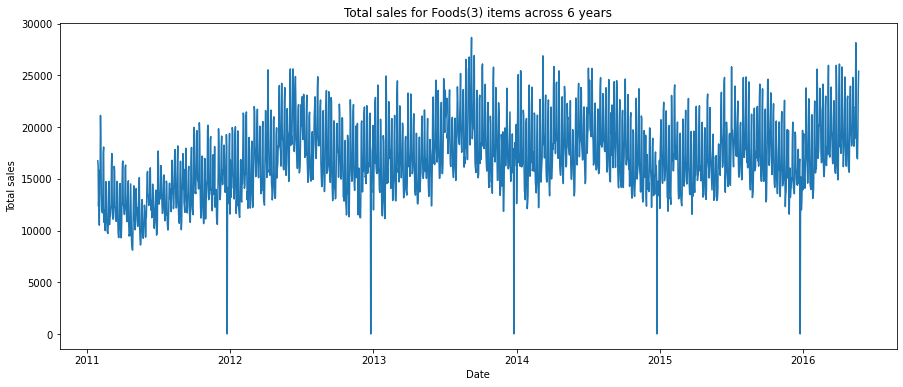

In [33]:
# Plot of total sales for foods_3 vs time 
plt.figure(figsize=(15,6))
plt.plot(df8.date, df8.FOODS_3)
plt.xlabel('Date')
plt.ylabel('Total sales')
plt.title('Total sales for Foods(3) items across 6 years')

There are sequential outliers in the data where the sales are 0 on certain days (perhaps closure days). Lets identify these:

In [22]:
df8[df8.FOODS_3 <= 5000]

,date,wday,month,d,event_name_1,event_type_1,FOODS_3
330,2011-12-25,2,12,d_331,Christmas,National,13
696,2012-12-25,4,12,d_697,Christmas,National,10
1061,2013-12-25,5,12,d_1062,Christmas,National,20
1426,2014-12-25,6,12,d_1427,Christmas,National,17
1791,2015-12-25,7,12,d_1792,Christmas,National,12


### Stationarity test: 

In [39]:
# Create dataframe with date index and FOODS_3 sales 
df9 = df8[[ 'date', 'FOODS_3']].set_index('date')
df9.head()

,FOODS_3
date,
2011-01-29,16741
2011-01-30,16333
2011-01-31,12343
2011-02-01,13764
2011-02-02,10525


In [42]:
# Augmented Dickey-Fuller test
df_adfuller = adfuller(df9, autolag = 'AIC')
print("Probability-Value: ", df_adfuller[1])

Probability-Value:  0.2825816409039398
